In [1]:
import serial
import matplotlib.pyplot as plt
import numpy as np
import math
from math import pi
import time
import pygame

pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import sys
import glob
import serial


def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result


In [3]:
class LidarDataReader():
    def __init__(self,ser):
        self.serial_port = serial_port
        self.baudrate = baudrate
        self.ser = ser

        #Array of points that will be plotted out
        self.points_x = np.full(360,0)
        self.points_y = np.full(360,0)
        self.distance = np.full(360,0)

        self.angle = np.linspace(0,359,360)
        self.c_vals = -np.sin(self.angle * pi/180.)
        self.s_vals = np.cos(self.angle * pi/180.)

        self.axis = plt.axis([-2500, 2500, -2500, 2500])

    def compute_distance(self,data):
        x = data[0] #distance
        x1= data[1] #distance mask
        x2= data[2] #distance quality
        x3= data[3] #distance quality mask
        if x1 & 0x80:
             return 0
        dist_mm = x | (( x1 & 0x3f) << 8) # distance is coded on 13 bits ? 14 bits ?
        return dist_mm

    def update_angle_distance_list(self, angle_index, data_list):
        for i, data in enumerate(data_list):
            angle = angle_index * 4 + i
            self.distance[angle] = self.compute_distance(data)

    def read_from_arduino(self):
        b = ord(self.ser.read(1))
        #check for start bit
        if b != 0xFA: return -1
        b = ord(self.ser.read(1))
        #check validity of angle bit
        if not (b >= 0xA0 and b <= 0xF9): return -2
        index = b - 0xA0
        speed = [b for b in self.ser.read(2)]
        b_data = [[b for b in self.ser.read(4)] for i in range(4)]
        return index, b_data

    def one_iteration(self):
        #read data from arduino
        result = self.read_from_arduino()
        #ignore bad reads
        if result == -1 or result == -2: return -1
        index, data = result
        self.update_angle_distance_list(index, data)
        return index

    def get_x_y(self, min_distance=1):
        x,y = self.distance*self.c_vals, self.distance*self.s_vals
        d_x_y_a = list(zip(self.distance,x,y,self.angle))
        filtered_d_x_y_a = filter(lambda x: x[0] > min_distance, d_x_y_a)
        d, x, y, a = zip(*filtered_d_x_y_a)
        return d, x, y, a

    def gradient(self):
        return np.gradient(self.distance)

    def jump_cluster(self, d, max_distance=200):
        cluster_index = 1
        cluster_list = np.full(len(d),0)
        for i in range(len(d)):
            cluster_list[i] = cluster_index
            if i+1 != len(d):
                if abs(d[i+1] - d[i]) > max_distance: cluster_index += 1
            else:
                if abs(d[i] - d[0]) < max_distance:
                    print(cluster_list)
                    cluster_list[cluster_list == cluster_index] = 1
                    print(cluster_list)
        return cluster_list

    def plot(self, pause=.01,cluster=True):
        try:
            d, x, y, a = self.get_x_y()
            if cluster:
                cluster = self.jump_cluster(d)
                self.scatter = plt.scatter(x,y, c=cluster, cmap='prism')
            else:
                self.scatter = plt.scatter(x, y, color='blue')
        except:
            print("dropped data")
        plt.pause(pause)
        self.scatter.remove()


In [4]:
car_template ='&{}:{}&'

def write_ser(speed_left,speed_right):
    ser.write(car_template.format(speed_left,speed_right).encode())

def stop():
    write_ser(0,0)


wasd_dict = {'w':'f','s':'b','a':'l','d':'r'}

step_time = 100.0 # miliseconds

class car_controller():
    def __init__(self,ser,step_time):
        self.ser = ser
        self.step_time = step_time
    def stop(self):
        write_ser(0,0)
    def forward(self,distance=18):
        '''
        for 1 second run
        towards lidar is backwards
        18cm ~ 100
        34cm ~150
        44cm ~ 200
        '''

        #if distance == 0 :
           # speed = 0
           # write_ser(speed,speed)
            #time.sleep(step_time/1000.)
        #else :
        print(distance)
        speed = 3.8 * abs(distance) + 30
        sign = distance/abs(distance)
        speed = max(speed,100)
        speed = min(speed,255)
        speed = -speed*sign
        write_ser(speed,speed)
        #time.sleep(1.)

    def turn(self,angle=math.pi/4):
        '''
        for 1 second run
        left is negative
        200 ~ 90 + 45 degrees
        150 ~ 45 degrees
        175 ~ 90 degrees
        '''
        speed = 100/math.pi * abs(angle) + 125
        print(speed)
        sign = angle/abs(angle)
        speed = max(speed,150)
        speed = min(speed,255)   
        speed = speed*sign
        write_ser(-speed,speed)
        #time.sleep(step_time)
    def text_inst(self,direction,distance):
        distance = abs(distance)
        if 'f' in direction:
            self.forward(distance)
        if 'b' in direction:
            self.forward(-1*distance)
        if 'r' in direction:
            self.turn(distance)
        if 'l' in direction:
            self.turn(-1*distance)
    def interpret_text(self,text_inst):
        if len(text_inst) > 1:
            try:
                text = text_inst[0]
                distance = float(text_inst[1:])
                self.text_inst(text,distance)
            except:
                print("wrong format: '[f/b/l/r][distance]'")
        else: 
            self.text_inst(wasd_dict[text_inst],.1)

    def follow_series(self,series):
        for inst in series:
            self.interpret_text(inst)

In [5]:
serial_ports()

['/dev/ttyACM0', '/dev/ttyS4', '/dev/ttyS0']

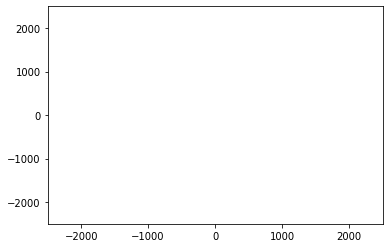

In [6]:
serial_port='/dev/ttyACM0'
#serial_port='/dev/tty.usbmodem14101'
baudrate = 115200
ser = serial.Serial(serial_port, baudrate, timeout=5)
ldr = LidarDataReader(ser=ser)

In [7]:
import time
time.sleep(5)

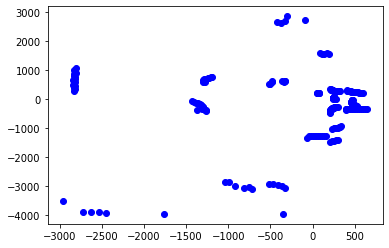

In [10]:
while True:
    angle = ldr.one_iteration()
    #update plot on 0
    if angle == 0:
        ldr.plot(cluster=False)
        break

In [11]:
pygame.init()

(5, 0)

In [12]:
#for lidar steering
clock = pygame.time.Clock()
pygame.key.set_repeat(100,100)


wasd_dict = {'w':'f','s':'b','a':'l','d':'r'}

step_time = 100.0 # miliseconds

car_ctrl = car_controller(ser,step_time=step_time)

In [13]:
# Initialize the joysticks.
pygame.joystick.init()

In [ ]:
# DONT RUN THIS CELL

size = (1000, 1000)
screen = pygame.display.set_mode(size)

done = False 
while not done:
    #event loop
    for event in pygame.event.get(): #user did something
        if event.type == pygame.QUIT: #user clicked close
            done = True
        #print("press keydown: ")
        if event.type == pygame.QUIT :
            playing = False
        if event.type == pygame.KEYDOWN :
            if event.key == pygame.K_w :
                print("w")
                car_ctrl.forward(10)
            if event.key == pygame.K_d :
                print("d")
                car_ctrl.turn(.1)
            if event.key == pygame.K_s :
                print("s")
                car_ctrl.forward(-.1)
            if event.key == pygame.K_a :
                print("a")
                car_ctrl.turn(-.1)
            if event.key == pygame.K_1 :
                playing = False
                
    # joystick code
    
        joystick_count = pygame.joystick.get_count()

        for i in range(joystick_count):
            joystick = pygame.joystick.Joystick(i)
            joystick.init()

            try:
                jid = joystick.get_instance_id()
            except AttributeError:
                # get_instance_id() is an SDL2 method
                jid = joystick.get_id()

            # Usually axis run in pairs, up/down for one, and left/right for
            # the other.
            axes = joystick.get_numaxes()
            leftright = joystick.get_axis(0)
            updown = joystick.get_axis(1)

            if updown>.5 :
                car_ctrl.forward(.1)
            elif leftright>.5 :
                car_ctrl.turn(-.1)
            elif updown<-.5 :
                car_ctrl.forward(-.1)
            elif leftright<-.5 :
                car_ctrl.turn(.1)
            else: car_ctrl.stop()
            clock.tick(60)
    
pygame.quit()

In [15]:
# Define some colors
BLACK    = (   0,   0,   0)
WHITE    = ( 255, 255, 255)
GREEN    = (   0, 255,   0)
RED      = ( 255,   0,   0)
BLUE     = (   0,   0, 255)

In [17]:
size = (1000, 1000)
screen = pygame.display.set_mode(size)

In [ ]:
pygame.display.set_caption("LIDAR")

In [ ]:
# Ignore the 3 cells above

# WORKING WINDOW FOR KEYBOARD ROBOT CONTROLS

# Define some colors
BLACK    = (   0,   0,   0)
WHITE    = ( 255, 255, 255)
GREEN    = (   0, 255,   0)
RED      = ( 255,   0,   0)
BLUE     = (   0,   0, 255)


size = (1000, 1000)
screen = pygame.display.set_mode(size)

pygame.display.set_caption("LIDAR")

#loop until close
done = False

#manage update speed
clock = pygame.time.Clock()

#main window loop
while not done:
    #event loop
    for event in pygame.event.get(): #user did something
        if event.type == pygame.QUIT: #user clicked close
            done = True
        #print("press keydown: ")
        if event.type == pygame.QUIT :
            playing = False
        if event.type == pygame.KEYDOWN :
            if event.key == pygame.K_w :
                print("w")
                car_ctrl.forward(.1)
            if event.key == pygame.K_d :
                print("d")
                car_ctrl.turn(.1)
            if event.key == pygame.K_s :
                print("s")
                car_ctrl.forward(-.1)
            if event.key == pygame.K_a :
                print("a")
                car_ctrl.turn(-.1)
            if event.key == pygame.K_1 :
                playing = False
                
            
                
    # control code
    # Drawing code
    
    #first clear screen to white, put drawing commands after this
    screen.fill(WHITE)
    
    pygame.draw.circle(screen, GREEN,  (50,50), 10)
    pygame.draw.rect(screen, GREEN, [50,50,100,100])

    
    angle = ldr.one_iteration()
    #update plot on 0
    if angle == 0:
        ds, xs, ys, a_s = ldr.get_x_y()
        max_val = 5000
        for x, y in zip(xs,ys):
            #scale the coordinates:
            x = (x+max_val/2)/max_val*size[0]
            y = (y+max_val/2)/max_val*size[1]
            pygame.draw.circle(screen, BLACK,  (x,y), 4)
        # update screen
        pygame.display.flip()
        print('update')
    
    #limit to 60 fps
    clock.tick(100)
    
    

update
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
update
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
w
0.1
s
-0.1
update
a
128.18309886183792
a
128.18309886183792


In [ ]:
import serial
import matplotlib.pyplot as plt
import numpy as np
import math
from math import pi
import time
import pygame

pygame.init()


car_template ='&{}:{}&'

def write_ser(speed_left,speed_right):
    ser.write(car_template.format(speed_left,speed_right).encode())

def stop():
    write_ser(0,0)



class car_controller():
    def __init__(self,ser,step_time):
        self.ser = ser
        self.step_time = step_time
    def forward(self,distance=18):
        '''
        for 1 second run
        towards lidar is backwards
        18cm ~ 100
        34cm ~150
        44cm ~ 200
        '''

        #if distance == 0 :
           # speed = 0
           # write_ser(speed,speed)
            #time.sleep(step_time/1000.)
        #else :
        print(distance)
        speed = 3.8 * abs(distance) + 30
        sign = distance/abs(distance)
        speed = max(speed,100)
        speed = min(speed,255)
        speed = -speed*sign
        write_ser(speed,speed)
        #time.sleep(1.)

    def turn(self,angle=math.pi/4):
        '''
        for 1 second run
        left is negative
        200 ~ 90 + 45 degrees
        150 ~ 45 degrees
        175 ~ 90 degrees
        '''
        speed = 100/math.pi * abs(angle) + 125
        print(speed)
        sign = angle/abs(angle)
        speed = max(speed,150)
        speed = min(speed,255)   
        speed = speed*sign
        write_ser(-speed,speed)
        #time.sleep(step_time)
    def text_inst(self,direction,distance):
        distance = abs(distance)
        if 'f' in direction:
            self.forward(distance)
        if 'b' in direction:
            self.forward(-1*distance)
        if 'r' in direction:
            self.turn(distance)
        if 'l' in direction:
            self.turn(-1*distance)
    def interpret_text(self,text_inst):
        if len(text_inst) > 1:
            try:
                text = text_inst[0]
                distance = float(text_inst[1:])
                self.text_inst(text,distance)
            except:
                print("wrong format: '[f/b/l/r][distance]'")
        else: 
            self.text_inst(wasd_dict[text_inst],.1)

    def follow_series(self,series):
        for inst in series:
            self.interpret_text(inst)
            

test_series= ['l1.5','r1.5','f30','b30']

if __name__ == "__main__":
    import argparse

    serial_port='/dev/ttyACM0'
    baudrate = 115200
    ser = serial.Serial(serial_port, baudrate, timeout=5)
    print(ser)
    car_ctrl = car_controller(ser,step_time=step_time)
    #car_ctrl.follow_series(test_series)
    #write_ser(200,200)

    playing = True
    while playing:
        #print("Press a Key: ")
        for event in pygame.event.get() :
            #print("press keydown: ")
            if event.type == pygame.QUIT :
                playing = False
            if event.type == pygame.KEYDOWN :
                if event.key == pygame.K_w :
                    print("w")
                    car_ctrl.forward(.1)
                if event.key == pygame.K_d :
                    print("d")
                    car_ctrl.turn(.1)
                if event.key == pygame.K_s :
                    print("s")
                    car_ctrl.forward(-.1)
                if event.key == pygame.K_a :
                    print("a")
                    car_ctrl.turn(-.1)
                if event.key == pygame.K_1 :
                    playing = False
        clock.tick(100)



pygame.quit()


Serial<id=0x7fdfb6ef1940, open=True>(port='/dev/ttyACM0', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=5, xonxoff=False, rtscts=False, dsrdtr=False)


In [13]:
# WORKING PYGAME WINDOW FOR JOYSTICK

import pygame


# Define some colors.
BLACK = pygame.Color('black')
WHITE = pygame.Color('white')


# This is a simple class that will help us print to the screen.
# It has nothing to do with the joysticks, just outputting the
# information.
class TextPrint(object):
    def __init__(self):
        self.reset()
        self.font = pygame.font.Font(None, 20)

    def tprint(self, screen, textString):
        textBitmap = self.font.render(textString, True, BLACK)
        screen.blit(textBitmap, (self.x, self.y))
        self.y += self.line_height

    def reset(self):
        self.x = 10
        self.y = 10
        self.line_height = 15

    def indent(self):
        self.x += 10

    def unindent(self):
        self.x -= 10


pygame.init()

# Set the width and height of the screen (width, height).
screen = pygame.display.set_mode((500, 700))

pygame.display.set_caption("My Game")

# Loop until the user clicks the close button.
done = False

# Used to manage how fast the screen updates.
clock = pygame.time.Clock()

# Initialize the joysticks.
pygame.joystick.init()

# Get ready to print.
textPrint = TextPrint()

# -------- Main Program Loop -----------
while not done:
    #
    # EVENT PROCESSING STEP
    #
    # Possible joystick actions: JOYAXISMOTION, JOYBALLMOTION, JOYBUTTONDOWN,
    # JOYBUTTONUP, JOYHATMOTION
    for event in pygame.event.get(): # User did something.
        if event.type == pygame.QUIT: # If user clicked close.
            done = True # Flag that we are done so we exit this loop.
        elif event.type == pygame.JOYBUTTONDOWN:
            print("Joystick button pressed.")
        elif event.type == pygame.JOYBUTTONUP:
            print("Joystick button released.")

    #
    # DRAWING STEP
    #
    # First, clear the screen to white. Don't put other drawing commands
    # above this, or they will be erased with this command.
    screen.fill(WHITE)
    textPrint.reset()

    # Get count of joysticks.
    joystick_count = pygame.joystick.get_count()

    textPrint.tprint(screen, "Number of joysticks: {}".format(joystick_count))
    textPrint.indent()

    # For each joystick:
    for i in range(joystick_count):
        joystick = pygame.joystick.Joystick(i)
        joystick.init()

        try:
            jid = joystick.get_instance_id()
        except AttributeError:
            # get_instance_id() is an SDL2 method
            jid = joystick.get_id()
        textPrint.tprint(screen, "Joystick {}".format(jid))
        textPrint.indent()

        # Get the name from the OS for the controller/joystick.
        name = joystick.get_name()
        textPrint.tprint(screen, "Joystick name: {}".format(name))

        try:
            guid = joystick.get_guid()
        except AttributeError:
            # get_guid() is an SDL2 method
            pass
        else:
            textPrint.tprint(screen, "GUID: {}".format(guid))

        # Usually axis run in pairs, up/down for one, and left/right for
        # the other.
        axes = joystick.get_numaxes()
        textPrint.tprint(screen, "Number of axes: {}".format(axes))
        textPrint.indent()

        for i in range(axes):
            axis = joystick.get_axis(i)
            textPrint.tprint(screen, "Axis {} value: {:>6.3f}".format(i, axis))
        textPrint.unindent()

        buttons = joystick.get_numbuttons()
        textPrint.tprint(screen, "Number of buttons: {}".format(buttons))
        textPrint.indent()

        for i in range(buttons):
            button = joystick.get_button(i)
            textPrint.tprint(screen,
                             "Button {:>2} value: {}".format(i, button))
        textPrint.unindent()

        hats = joystick.get_numhats()
        textPrint.tprint(screen, "Number of hats: {}".format(hats))
        textPrint.indent()

        # Hat position. All or nothing for direction, not a float like
        # get_axis(). Position is a tuple of int values (x, y).
        for i in range(hats):
            hat = joystick.get_hat(i)
            textPrint.tprint(screen, "Hat {} value: {}".format(i, str(hat)))
        textPrint.unindent()

        textPrint.unindent()

    #
    # ALL CODE TO DRAW SHOULD GO ABOVE THIS COMMENT
    #

    # Go ahead and update the screen with what we've drawn.
    pygame.display.flip()

    # Limit to 20 frames per second.
    clock.tick(20)

# Close the window and quit.
# If you forget this line, the program will 'hang'
# on exit if running from IDLE.
pygame.quit()

Joystick button pressed.
Joystick button released.
Joystick button pressed.
Joystick button pressed.
Joystick button released.
Joystick button pressed.
Joystick button released.
Joystick button released.
Joystick button pressed.
Joystick button pressed.
Joystick button released.
Joystick button released.
Joystick button pressed.
Joystick button pressed.
Joystick button pressed.
Joystick button released.
Joystick button released.
Joystick button released.
Joystick button pressed.
Joystick button pressed.
Joystick button released.
Joystick button released.
Joystick button pressed.
Joystick button pressed.
Joystick button pressed.
Joystick button released.
Joystick button pressed.
Joystick button released.
Joystick button released.
Joystick button released.
Joystick button pressed.
Joystick button pressed.
Joystick button pressed.
Joystick button released.
Joystick button pressed.
Joystick button released.
Joystick button released.
Joystick button released.


In [12]:
# COMPLETED PYGAME WINDOW STILL NEEDS WORK

import pygame



# Define some colors
BLACK    = (   0,   0,   0)
WHITE    = ( 255, 255, 255)
GREEN    = (   0, 255,   0)
RED      = ( 255,   0,   0)
BLUE     = (   0,   0, 255)


size = (1000, 1000)
screen = pygame.display.set_mode(size)

pygame.display.set_caption("LIDAR")

#loop until close
done = False

#manage update speed
clock = pygame.time.Clock()

#main window keyboard loop
while not done:
    #event loop
    for event in pygame.event.get(): #user did something
        if event.type == pygame.QUIT: #user clicked close
            done = True
        #print("press keydown: ")
        if event.type == pygame.QUIT :
            playing = False
        if event.type == pygame.KEYDOWN :
            if event.key == pygame.K_w :
                print("w")
                car_ctrl.forward(.1)
            if event.key == pygame.K_d :
                print("d")
                car_ctrl.turn(.1)
            if event.key == pygame.K_s :
                print("s")
                car_ctrl.forward(-.1)
            if event.key == pygame.K_a :
                print("a")
                car_ctrl.turn(-.1)
            if event.key == pygame.K_1 :
                playing = False
                
# main window joystick loop

joystick_count = pygame.joystick.get_count()
    
for i in range(joystick_count):
    joystick = pygame.joystick.Joystick(i)
    joystick.init()

    try:
        jid = joystick.get_instance_id()
    except AttributeError:
        # get_instance_id() is an SDL2 method
        jid = joystick.get_id()

    # Usually axis run in pairs, up/down for one, and left/right for
    # the other.
    axes = joystick.get_numaxes()
    leftright = joystick.get_axis(0)
    updown = joystick.get_axis(1)

    if updown>.5 :
        car_ctrl.forward(.1)
    elif leftright>.5 :
        car_ctrl.turn(-.1)
    elif updown<-.5 :
        car_ctrl.forward(-.1)
    elif leftright<-.5 :
        car_ctrl.turn(.1)
    else: car_ctrl.stop()
    clock.tick(60)
                
    # control code
    # Drawing code
    
    #first clear screen to white, put drawing commands after this
    screen.fill(WHITE)
    
    pygame.draw.circle(screen, GREEN,  (50,50), 10)
    pygame.draw.rect(screen, GREEN, [50,50,100,100])

    
    angle = ldr.one_iteration()
    #update plot on 0
    if angle == 0:
        ds, xs, ys, a_s = ldr.get_x_y()
        max_val = 5000
        for x, y in zip(xs,ys):
            #scale the coordinates:
            x = (x+max_val/2)/max_val*size[0]
            y = (y+max_val/2)/max_val*size[1]
            pygame.draw.circle(screen, BLACK,  (x,y), 4)
        # update screen
        pygame.display.flip()
        print('update')
    
    #limit to 60 fps
    clock.tick(100)


In [16]:
# WORKING JOYSTICK ROBOT CONTROLS (WORKING PYGAME WINDOW) 

import pygame



# Define some colors
BLACK    = (   0,   0,   0)
WHITE    = ( 255, 255, 255)
GREEN    = (   0, 255,   0)
RED      = ( 255,   0,   0)
BLUE     = (   0,   0, 255)


size = (1000, 1000)
screen = pygame.display.set_mode(size)

pygame.display.set_caption("LIDAR")


# main window joystick loop


# Loop until the user clicks the close button.
done = False

# Used to manage how fast the screen updates.
clock = pygame.time.Clock()

# Initialize the joysticks.
pygame.joystick.init()

                
# -------- Main Program Loop -----------
while not done:
    #
    # EVENT PROCESSING STEP
    #
    # Possible joystick actions: JOYAXISMOTION, JOYBALLMOTION, JOYBUTTONDOWN,
    # JOYBUTTONUP, JOYHATMOTION
    for event in pygame.event.get(): # User did something.
        if event.type == pygame.QUIT: # If user clicked close.
            done = True # Flag that we are done so we exit this loop.
        elif event.type == pygame.JOYBUTTONDOWN:
            print("Joystick button pressed.")
        elif event.type == pygame.JOYBUTTONUP:
            print("Joystick button released.")

        try:
            joystick_count = pygame.joystick.get_count()
            for i in range(joystick_count):
                joystick = pygame.joystick.Joystick(i)
                joystick.init()
                axes = joystick.get_numaxes()
                leftright = joystick.get_axis(0)
                updown = joystick.get_axis(1)
            
                if updown>.2 :
                    car_ctrl.forward(1)
                elif leftright>.2 :
                    car_ctrl.turn(-1)
                elif updown<-.2 :
                    car_ctrl.forward(-1)
                elif leftright<-.2 :
                    car_ctrl.turn(1)
                
        except Exception as e:
            print(e)
            done=True

#         # Get count of joysticks.
#         joystick_count = pygame.joystick.get_count()


#         # For each joystick:
#         for i in range(joystick_count):
#             joystick = pygame.joystick.Joystick(i)
#             joystick.init()


#             try:
#                 jid = joystick.get_instance_id()
#             except AttributeError:
#                 # get_instance_id() is an SDL2 method
#                 jid = joystick.get_id()


#             try:
#                 guid = joystick.get_guid()
#             except AttributeError:
#                 # get_guid() is an SDL2 method
#                 pass


#             # Usually axis run in pairs, up/down for one, and left/right for
#             # the other.
#             axes = joystick.get_numaxes()
#             leftright = joystick.get_axis(0)
#             updown = joystick.get_axis(1)
            
            
#             if updown>.5 :
#                 car_ctrl.forward(.1)
#             elif leftright>.5 :
#                 car_ctrl.turn(-.1)
#             elif updown<-.5 :
#                 car_ctrl.forward(-.1)
#             elif leftright<-.5 :
#                 car_ctrl.turn(.1)
#             else: car_ctrl.stop()
#             clock.tick(60)


            
                
    # control code
    # Drawing code
    
    #first clear screen to white, put drawing commands after this
    screen.fill(WHITE)
    
    pygame.draw.circle(screen, GREEN,  (50,50), 10)
    pygame.draw.rect(screen, GREEN, [50,50,100,100])

    
    angle = ldr.one_iteration()
    #update plot on 0
    if angle == 0:
        ds, xs, ys, a_s = ldr.get_x_y()
        max_val = 5000
        for x, y in zip(xs,ys):
            #scale the coordinates:
            x = (x+max_val/2)/max_val*size[0]
            y = (y+max_val/2)/max_val*size[1]
            pygame.draw.circle(screen, BLACK,  (x,y), 4)
        # update screen
        pygame.display.flip()
        print('update')
        
    
    
pygame.quit()    


update
update
update
update
update
update
update
-1
-1
update
update
update
update
update
update
update
-1
update
update
update
update
update
update
update
update
-1
update
update
update
update
update
update
update
update
-1
update
update
update
update
update
update
update
update
update
156.83098861837908
156.83098861837908
update
update
update
update
update
-1
update
update
update
update
update
update
update
update
update
-1
update
update
update
update
update
update
1
update
update
update
update
update
update
update
update
update
update
-1
update
update
update
update
update
update
update
update
update
update
update
156.83098861837908
update
update
update
update
update
update
update
update
156.83098861837908
update
update
update
update
update
update
156.83098861837908
update
update
update
update
update
update
update
156.83098861837908
update
update
update
update
update
update
update
update
update
156.83098861837908
update
update
update
update
update
update
156.83098861837908
update
upd

ValueError: not enough values to unpack (expected 4, got 0)

In [ ]:
# EDITED JOYSTCIK CODE

import pygame




pygame.init()



# Loop until the user clicks the close button.
done = False

# Used to manage how fast the screen updates.
clock = pygame.time.Clock()

# Initialize the joysticks.
pygame.joystick.init()

                

# -------- Main Program Loop -----------
while not done:
    #
    # EVENT PROCESSING STEP
    #
    # Possible joystick actions: JOYAXISMOTION, JOYBALLMOTION, JOYBUTTONDOWN,
    # JOYBUTTONUP, JOYHATMOTION
    for event in pygame.event.get(): # User did something.
        if event.type == pygame.QUIT: # If user clicked close.
            done = True # Flag that we are done so we exit this loop.
        if event.type == pygame.QUIT :
            playing = False
        elif event.type == pygame.JOYBUTTONDOWN:
            print("Joystick button pressed.")
        elif event.type == pygame.JOYBUTTONUP:
            print("Joystick button released.")

  

        # Get count of joysticks.
        joystick_count = pygame.joystick.get_count()


        # For each joystick:
        for i in range(joystick_count):
            joystick = pygame.joystick.Joystick(i)
            joystick.init()


            try:
                jid = joystick.get_instance_id()
            except AttributeError:
                # get_instance_id() is an SDL2 method
                jid = joystick.get_id()


            try:
                guid = joystick.get_guid()
            except AttributeError:
                # get_guid() is an SDL2 method
                pass


            # Usually axis run in pairs, up/down for one, and left/right for
            # the other.
            axes = joystick.get_numaxes()


            for i in range(axes):
                axis = joystick.get_axis(i)


            buttons = joystick.get_numbuttons()

            for i in range(buttons):
                button = joystick.get_button(i)

            hats = joystick.get_numhats()


            # Hat position. All or nothing for direction, not a float like
            # get_axis(). Position is a tuple of int values (x, y).
            for i in range(hats):
                hat = joystick.get_hat(i)
